https://www.pymc-labs.com/blog-posts/markov-process/

In [51]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az

from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")
import mpltern

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [2]:
president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls.csv")

In [3]:
df = pd.read_csv("../Data/raw/president_polls.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[(df['party'].isin(['REP', 'DEM']) == False) & (df['answer'] != 'Kennedy'), 'party'] = 'OTH'
df.loc[df['answer'] == 'Kennedy', 'party'] = 'IND'
df = df[df['party'] != 'OTH']

In [4]:
df['date'] = pd.to_datetime(df['end_date'])
#df = df[df['date'] >= '2023-11-05'] #Only polls since one year before election
df['week'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_63499/2321513912.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['end_date'])


In [5]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [6]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way["IND"] = 0
df_2way[['DEM', 'GOP', 'IND']] = df_2way[['DEM', 'GOP', 'IND']].div(df_2way[['DEM', 'GOP', 'IND']].sum(axis=1), axis=0)

df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way['type'] = '2way'

In [7]:
df3 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden', 'Robert F. Kennedy'})

df_count = df3.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df3.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_3way = df_polls.merge(df_count)
df_3way = df_3way.rename(columns={'REP':'GOP'})
df_3way[['DEM', 'GOP', 'IND']] = df_3way[['DEM', 'GOP', 'IND']].div(df_3way[['DEM', 'GOP', 'IND']].sum(axis=1), axis=0)

df_3way['sample_size'] = round(df_3way['sample_size'] * (df_3way['DEM'] + df_3way['GOP'] + df_3way['IND'])/100)
df_3way['type'] = '3way'

In [8]:
df4 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Robert F. Kennedy', 'Joe Biden'})

df_count = df4.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df4.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way_bk = df_polls.merge(df_count)
df_2way_bk["GOP"] = 0
df_2way_bk[['DEM', 'GOP', 'IND']] = df_2way_bk[['DEM', 'GOP', 'IND']].div(df_2way_bk[['DEM', 'GOP', 'IND']].sum(axis=1), axis=0)
df_2way_bk['sample_size'] = round(df_2way_bk['sample_size'] * (df_2way_bk['DEM'] + df_2way_bk['IND'])/100)
df_2way_bk['type'] = '2way_bk'

In [9]:
df5 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Robert F. Kennedy', 'Donald Trump'})

df_count = df5.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df5.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way_tk = df_polls.merge(df_count)
df_2way_tk = df_2way_tk.rename(columns={'REP':'GOP'})
df_2way_tk["DEM"] = 0
df_2way_tk[['DEM', 'GOP', 'IND']] = df_2way_tk[['DEM', 'GOP', 'IND']].div(df_2way_tk[['DEM', 'GOP', 'IND']].sum(axis=1), axis=0)
df_2way_tk['sample_size'] = round(df_2way_tk['sample_size'] * (df_2way_tk['GOP'] + df_2way_tk['IND'])/100)
df_2way_tk['type'] = '2way_tk'

In [10]:
df = pd.concat([df_2way, df_3way, df_2way_bk, df_2way_tk])
df.dropna()
df['obs_id'] = range(len(df))
df = df.set_index('date')

# Apply the function to create 'type_id' column
df['type_bt'] = (df['type'] == '2way').astype(int)
df['type_btk'] = (df['type'] == '3way').astype(int)
df['type_bk'] = (df['type'] == '2way_bk').astype(int)
df['type_tk'] = (df['type'] == '2way_tk').astype(int)

Two way Biden vs Trump, it's a dead tie

In [11]:
df_2way.query("state == 'US'")[['DEM', 'GOP']].describe()

,DEM,GOP
count,1432.000000,1432.000000
mean,0.498513,0.501487
std,0.018701,0.018701
min,0.415584,0.383562
25%,0.488372,0.488372
50%,0.500000,0.500000
75%,0.511628,0.511628
max,0.616438,0.584416


Two way Biden vs Kennedy, Kennedy leads by 10% (only one observation)

In [12]:
df_2way_bk.query("state == 'US'")[['DEM', 'IND']].describe()

,DEM,IND
count,1.000000,1.000000
mean,0.459184,0.540816
std,NaN,NaN
min,0.459184,0.540816
25%,0.459184,0.540816
50%,0.459184,0.540816
75%,0.459184,0.540816
max,0.459184,0.540816


Two way Trump vs Kennedy, they are tied (only one observation)

In [13]:
df_2way_tk.query("state == 'US'")[['GOP', 'IND']].describe()

,GOP,IND
count,1.00000,1.00000
mean,0.49702,0.50298
std,NaN,NaN
min,0.49702,0.50298
25%,0.49702,0.50298
50%,0.49702,0.50298
75%,0.49702,0.50298
max,0.49702,0.50298


Three way race, Trump leads Biden by 3%. We can conclude that Kennedy takes more votes from Biden and is a serious factor in the race.

In [14]:
df_3way.query("state == 'US'")[['DEM', 'GOP', 'IND']].describe()

,DEM,GOP,IND
count,266.000000,266.000000,266.000000
mean,0.425354,0.454473,0.120174
std,0.029874,0.024621,0.043564
min,0.347368,0.371134,0.022472
25%,0.404923,0.441922,0.094993
50%,0.425287,0.457249,0.116561
75%,0.445443,0.472373,0.146067
max,0.494382,0.501155,0.243902


In [15]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(10).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(10).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2021, and they have been ramping up since.

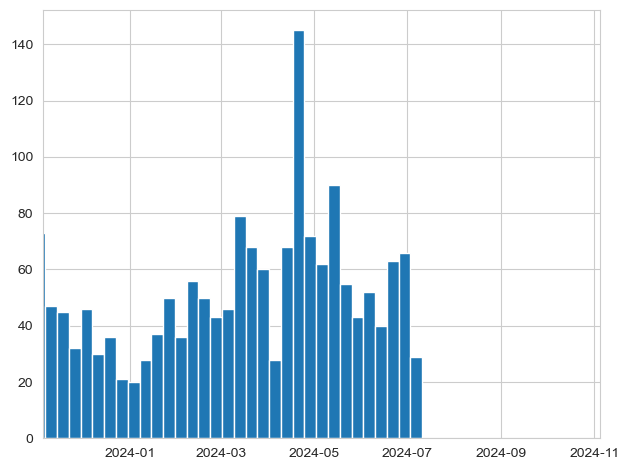

In [16]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2023, 11, 5), dt.datetime(2024, 11, 5))

plt.tight_layout()
plt.show()

In [17]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Probability Panel,Live Phone/Text-to-Web,IVR/Online Panel,IVR/Online Panel/Text-to-Web,App Panel,IVR/Online Panel/Email,Online Panel/Text-to-Web/Text,IVR/Text-to-Web
pollster,,,,,,,,,,,
All,2927,1644,263,135,128,109,74,63,55,55,50
Morning Consult,708,708,0,0,0,0,0,0,0,0,0
Emerson,237,0,0,0,0,51,68,0,55,0,2
YouGov,187,187,0,0,0,0,0,0,0,0,0
Redfield & Wilton Strategies,144,144,0,0,0,0,0,0,0,0,0
John Zogby Strategies,105,105,0,0,0,0,0,0,0,0,0
Echelon Insights,87,80,0,0,7,0,0,0,0,0,0
Big Data Poll,75,0,0,0,0,0,0,0,0,55,0
McLaughlin,71,58,0,0,13,0,0,0,0,0,0


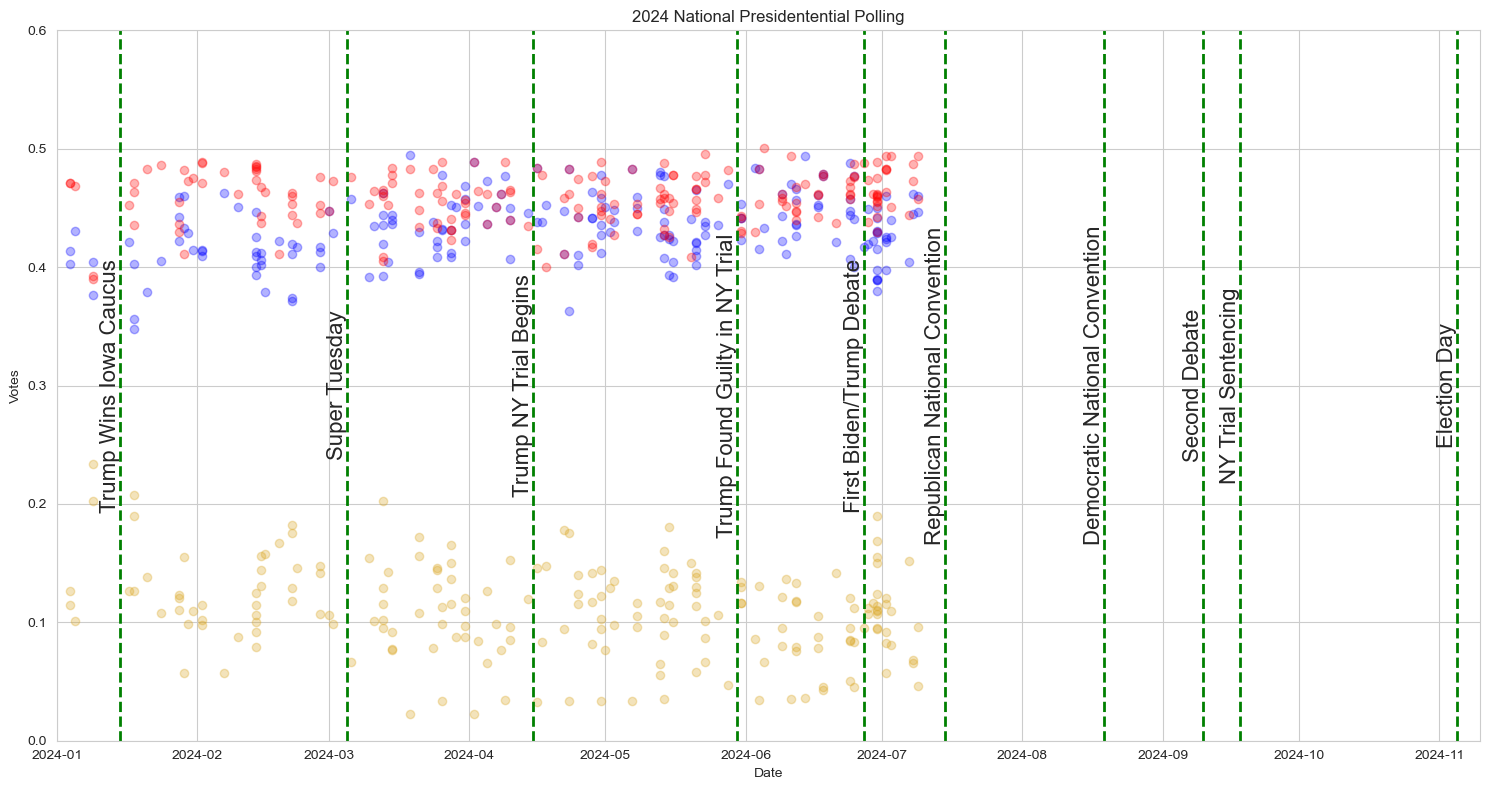

In [18]:
dem_votes = df_3way.query("state == 'US'")["DEM"].values
gop_votes = df_3way.query("state == 'US'")["GOP"].values
ind_votes = df_3way.query("state == 'US'")["IND"].values

dates = df_3way.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.3, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.3, color='red', label="Trump")
ax.plot(dates, ind_votes, "o", alpha=0.3, color='goldenrod', label="Kennedy")

# Set limits and labels
ax.set_ylim(0, 0.6)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Biden/Trump Debate'),
            (dt.datetime(2024, 7, 15), 'Republican National Convention'),
            (dt.datetime(2024, 8, 19), 'Democratic National Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

# Add large blue dot at the final actual national popular vote for Biden
#ax.plot(dt.datetime(2024, 11, 5), .523, "o", markersize=25, color='blue', alpha=1)

# Add large red dot at the final actual national popular vote for Trump
#ax.plot(dt.datetime(2024, 11, 5), .477, "o", markersize=25, color='red', alpha=1)

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.3, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)


plt.tight_layout()
plt.show()

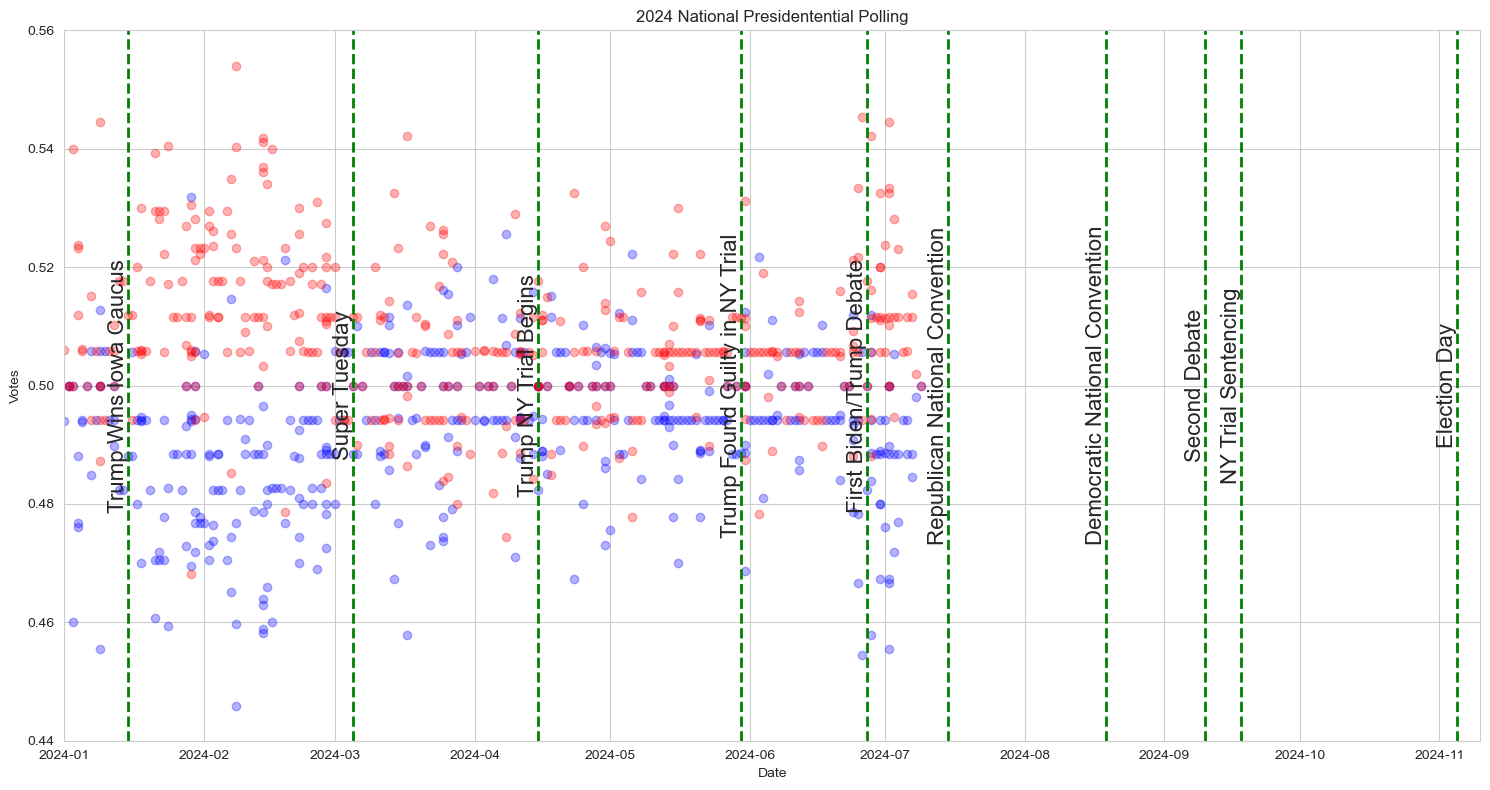

In [19]:
dem_votes = df_2way.query("state == 'US'")["DEM"].values
gop_votes = df_2way.query("state == 'US'")["GOP"].values

dates = df_2way.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.3, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.3, color='red', label="Trump")

# Set limits and labels
ax.set_ylim(0.44, 0.56)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Biden/Trump Debate'),
            (dt.datetime(2024, 7, 15), 'Republican National Convention'),
            (dt.datetime(2024, 8, 19), 'Democratic National Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

# Add large blue dot at the final actual national popular vote for Biden
#ax.plot(dt.datetime(2024, 11, 5), .523, "o", markersize=25, color='blue', alpha=1)

# Add large red dot at the final actual national popular vote for Trump
#ax.plot(dt.datetime(2024, 11, 5), .477, "o", markersize=25, color='red', alpha=1)

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.5, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Daily standard deviation in polls')

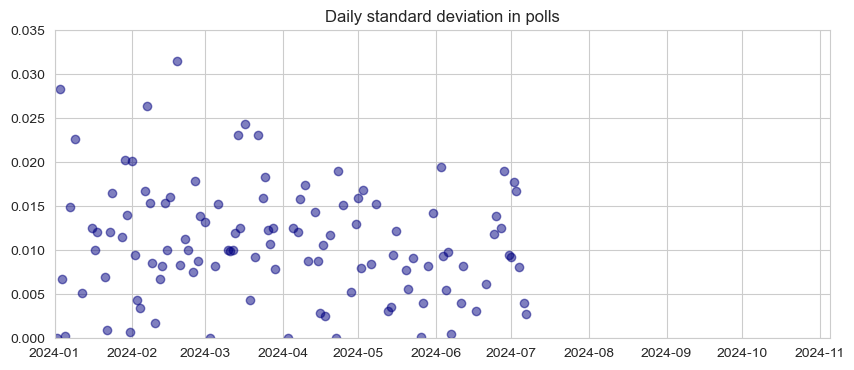

In [20]:
rolling_std = (
    df_2way.query("state == 'US'")[["date", "DEM", "GOP"]]
    .reset_index()
    .groupby(["date"])
    .std()
    .reset_index()[["date", "DEM", "GOP"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_std.date,
    rolling_std.DEM.values,
    "o",
    color = 'navy',
    alpha=0.5,
)

ax.set_ylim(0, .035)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("Daily standard deviation in polls")

Text(0.5, 1.0, 'Daily standard deviation in polls')

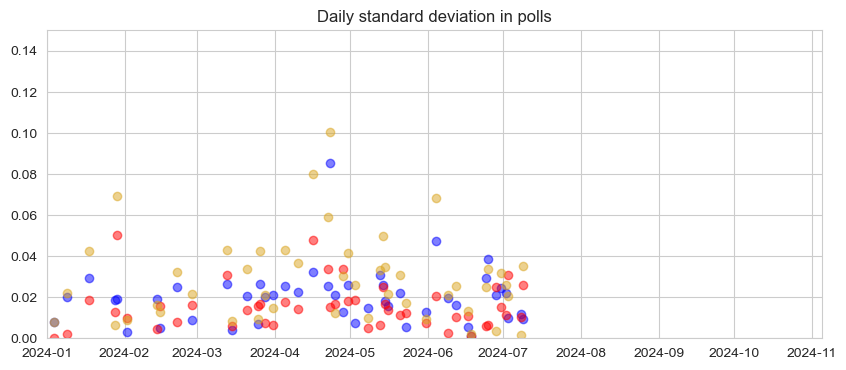

In [21]:
rolling_std = (
    df_3way.query("state == 'US'")[["date", "DEM", "GOP", "IND"]]
    .reset_index()
    .groupby(["date"])
    .std()
    .reset_index()[["date", "DEM", "GOP", "IND"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_std.date,
    rolling_std.DEM.values,
    "o",
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.GOP.values,
    "o",
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.IND.values,
    "o",
    color = 'goldenrod',
    alpha=0.5,
)

ax.set_ylim(0, .15)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("Daily standard deviation in polls")

We can see here that the polling methodology affects responses.

In [22]:
df.query("state == 'US'").query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'App Panel']")[['methodology','DEM','GOP','IND']].groupby("methodology").mean()

,DEM,GOP,IND
methodology,,,
App Panel,0.472678,0.516213,0.011109
Live Phone,0.476957,0.483896,0.039147
Online Panel,0.491206,0.494366,0.014428
Probability Panel,0.478077,0.481602,0.040320


We can see that Trump fairly consistently out-performs on App Panel polls.

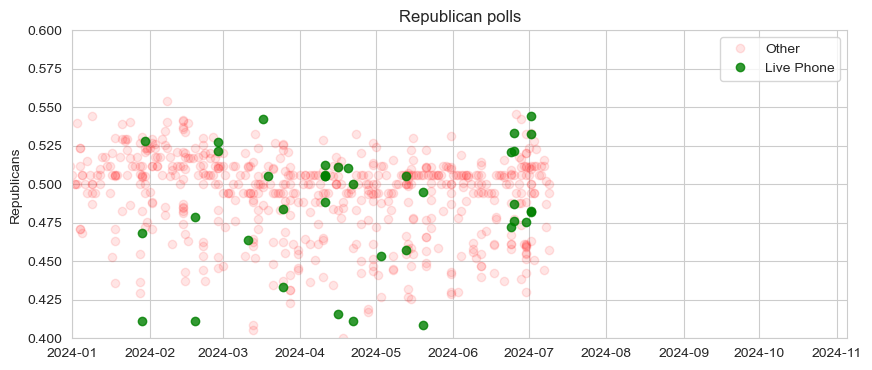

In [23]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "Live Phone"]
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "Live Phone"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["GOP"].values, "o", alpha=0.1, color = 'red', label="Other")
ax.plot(dates_face, face["GOP"].values, "o", alpha=.8, color = 'green', label="Live Phone")
ax.set_ylim(.4, .6)
ax.set_ylabel("Republicans")
ax.set_title("Republican polls")

ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.legend()

In [24]:
df["margin"] = df.apply(lambda row: row['DEM'] - row['IND'] if row['type'] == '2way_bk' else
                        (row['IND'] - row['GOP'] if row['type'] == '2way_tk' else
                         row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "IND", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [25]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]
df["diff_IND"] = df["IND"] - df["IND_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,type_tk,margin,GOP_mean,DEM_mean,IND_mean,margin_mean,diff_GOP,diff_DEM,diff_IND,diff_margin
0,2024-07-11,87369,202657,1878,SoCal Research,Online Panel,VA,a,10.0,2024,...,0,0.03,0.49,0.51,0.00,0.02,-0.01,0.01,0.00,0.02
1,2024-07-09,87367,202654,241,Ipsos,Probability Panel,US,rv,20.0,2024,...,0,0.00,0.49,0.51,0.00,0.02,0.01,-0.01,0.00,-0.02
2,2024-07-08,87361,202461,1102,Emerson,IVR/Online Panel/Text-to-Web,US,rv,14.0,2024,...,0,-0.00,0.51,0.49,0.00,-0.02,-0.01,0.01,0.00,0.02
3,2024-07-07,87351,202394,1189,Morning Consult,Online Panel,US,rv,113.0,2024,...,0,-0.02,0.51,0.49,0.00,-0.02,-0.00,0.00,0.00,0.00
4,2024-07-07,87375,202715,370,Pew,Probability Panel,US,rv,77.0,2024,...,0,-0.03,0.51,0.49,0.00,-0.02,0.00,-0.00,0.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,2024-04-21,86827,198199,1705,John Zogby Strategies,Online Panel,WV,lv,4.0,2024,...,1,-0.31,0.51,0.00,0.49,-0.01,0.15,0.00,-0.15,-0.30
2923,2024-04-21,86829,198203,1705,John Zogby Strategies,Online Panel,WI,lv,5.0,2024,...,1,-0.01,0.51,0.00,0.49,-0.01,-0.00,0.00,0.00,0.00
2924,2024-04-21,86830,198206,1705,John Zogby Strategies,Online Panel,WY,lv,2.0,2024,...,1,-0.19,0.51,0.00,0.49,-0.01,0.09,0.00,-0.09,-0.18
2925,2024-04-21,86832,198401,1705,John Zogby Strategies,Online Panel,US,lv,237.0,2024,...,1,0.01,0.51,0.00,0.49,-0.01,-0.01,0.00,0.01,0.02


Trump has a much greater lead in a three-way race:

In [26]:
100*df.query("state == 'US'").groupby('type')[['margin']].mean()

,margin
type,
2way,-0.297457
2way_bk,-8.163265
2way_tk,0.595948
3way,-2.911930


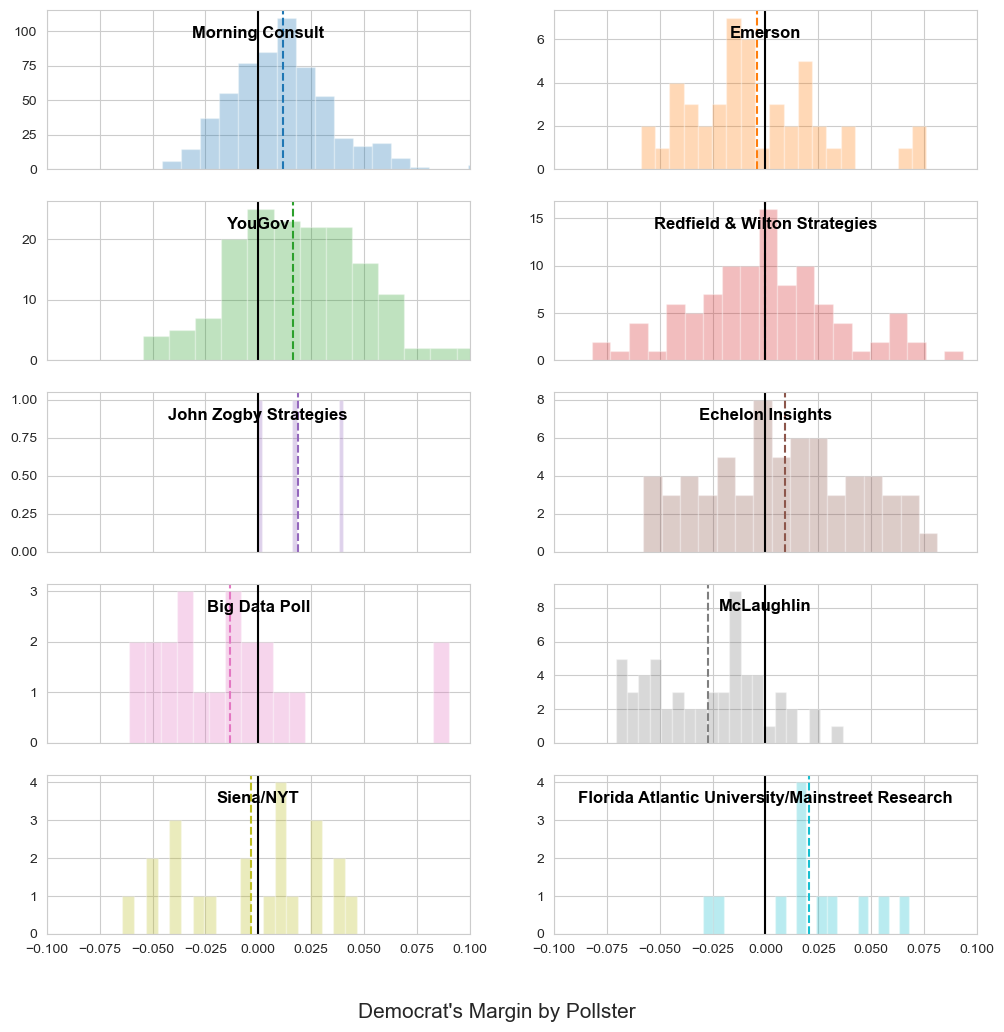

In [27]:
POLLSTER_VALS = {
    pollster: df.query("state == 'US'")[df.query("state == 'US'")["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.1, .1)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

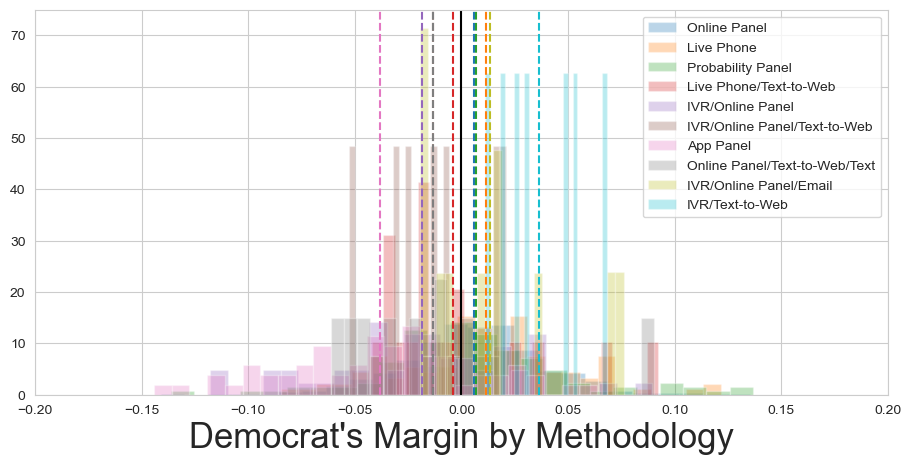

In [28]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in METHODS_top
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method, bins=25, density=True)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-.2, .2)
ax.set_xlabel(r"Democrat's Margin by Methodology", fontsize=25)
ax.legend();

In [29]:
df = df[~df['type'].isin(['2way_bk', '2way_tk'])]
df = df.dropna()

In [30]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

day_id, day = df.set_index(
    ["day"]
).index.factorize(sort=True)
day = np.concatenate([day, np.arange(max(day)+1, 1)])

party_id, party = [0,1,2], ['DEM','GOP','IND']

week = np.arange(min(week), 1)

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [31]:
with pm.Model(coords=COORDS) as pooled_popularity_simple:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    #dem_state_multi = pm.Normal("dem_state_multi", 1, 0.2, dims="state")
    dem_pop_effect = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")
    dem_day_effect = pm.GaussianRandomWalk("dem_day_effect", sigma=dem_sigma, init_dist=pm.Normal.dist(mu=-0.025, sigma=0.1), dims="day")
    dem_sigma_3way = pm.HalfNormal("dem_sigma_3way", sigma=0.1) + epsilon   
    dem_3way_walk = pm.GaussianRandomWalk("dem_3way_walk", sigma=dem_sigma_3way, init_dist=pm.Normal.dist(mu=0.148, sigma=0.1), dims="day")

    gop_sigma = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.2, dims="pollster")
    gop_method_effect = pm.Normal("gop_method_effect", 0, 0.2, dims="method")
    gop_state_effect = pm.Normal("gop_state_effect", 0, 0.2, dims="state")
    #gop_state_multi = pm.Normal("gop_state_multi", 1, 0.2, dims="state")
    gop_pop_effect = pm.Normal("gop_pop_effect", 0, 0.2, dims="population")
    gop_day_effect = pm.GaussianRandomWalk("gop_day_effect", sigma=gop_sigma, init_dist=pm.Normal.dist(mu=0.031, sigma=0.1), dims="day")
    gop_sigma_3way = pm.HalfNormal("gop_sigma_3way", sigma=0.1) + epsilon   
    gop_3way_walk = pm.GaussianRandomWalk("gop_3way_walk", sigma=gop_sigma_3way, init_dist=pm.Normal.dist(mu=0.095, sigma=0.1), dims="day")

    ind_sigma = pm.HalfNormal("ind_sigma", sigma=0.05) + epsilon
    ind_pollster_effect = pm.Normal("ind_pollster_effect", 0, 0.2, dims="pollster")
    ind_method_effect = pm.Normal("ind_method_effect", 0, 0.2, dims="method")
    ind_state_effect = pm.Normal("ind_state_effect", 0, 0.2, dims="state")
    #ind_state_multi = pm.Normal("ind_state_multi", 1, 0.2, dims="state")
    ind_pop_effect = pm.Normal("ind_pop_effect", 0, 0.1, dims="population")
    ind_day_effect = pm.GaussianRandomWalk("ind_day_effect", sigma=ind_sigma, init_dist=pm.Normal.dist(mu=-1.567, sigma=0.05), dims="day")

    type_btk = pm.Data("type_btk", df['type_btk'])
    type_bt = pm.Data("type_bt", df['type_bt'])

    dem_polling = (1 - dem_3way_walk[day_id] * type_btk) * pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        #dem_state_multi[state_id] *
        dem_day_effect[day_id]
    )

    gop_polling = (1 - gop_3way_walk[day_id] * type_btk) * pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        #gop_state_multi[state_id] *
        gop_day_effect[day_id]
    )

    ind_polling = (1 - type_bt) * pm.math.invlogit(
        ind_pollster_effect[pollster_id] +
        ind_method_effect[method_id] +
        ind_pop_effect[population_id] +
        ind_state_effect[state_id] +
        #ind_state_multi[state_id] *
        ind_day_effect[day_id]
    )

    dem_vote = pm.Binomial(
        "dem_vote",
        p=dem_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['DEM'],
        dims="observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p=gop_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['GOP'],
        dims="observation",
    )

    ind_vote = pm.Binomial(
        "ind_vote",
        p=ind_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['IND'],
        dims="observation",
    )

    polling_error_dem = pm.Normal("polling_error_dem", 0, .05)
    polling_error_gop = pm.Normal("polling_error_gop", 0, .05)
    polling_error_ind = pm.Deterministic("polling_error_ind",-(polling_error_dem + polling_error_gop))

    # Sampling
    idata = pm.sample(draws=1000, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_pop_effect, dem_day_effect, dem_sigma_3way, dem_3way_walk, gop_sigma, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_pop_effect, gop_day_effect, gop_sigma_3way, gop_3way_walk, ind_sigma, ind_pollster_effect, ind_method_effect, ind_state_effect, ind_pop_effect, ind_day_effect, polling_error_dem, polling_error_gop]
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pytensor/compile/function/types.py:1138: UserWarning: aliased relationship between Function arguments 879, 879 will not be preserved by un-pickling operation
  warnings.warn(


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 3497 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 4 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 6 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 9 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat st

In [32]:
states = df['state'].unique()
parties = ['dem', 'gop', 'ind', 'margin']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [104]:
a = pd.DataFrame(idata.posterior.dem_state_effect.sel(state='GA').values.flatten())

array([[<Axes: title={'center': '0'}>]], dtype=object)

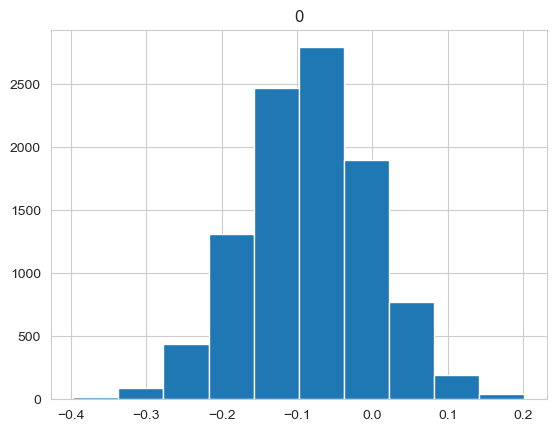

In [105]:
a.hist()

In [106]:
a = pd.DataFrame(idata.posterior.polling_error_ind.values.flatten())

array([[<Axes: title={'center': '0'}>]], dtype=object)

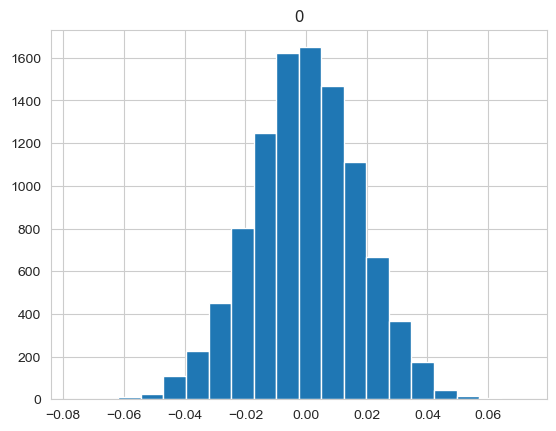

In [107]:
(np.exp(a)/(1+np.exp(a))-.5).hist(bins=20)

In [140]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean =  pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

#for d in tqdm(day):
for d in [-116]:
    for state in states:
        for party in parties[:2]:
            df_results[f"{state}_{party}"] = (
    (1 - idata.posterior[f"{party}_3way_walk"].sel(day=d)) * inv_logit(
        (idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
         idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marquette Law School")
        )/2 +
        (idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
         idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2) +
         idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone/Online Panel', drop=True).mean(axis=2)
        )/3 + 
        idata.posterior[f"{party}_pop_effect"].sel(population="rv") +
        idata.posterior[f"{party}_state_effect"].sel(state=f"{state}") +
        #idata.posterior[f"{party}_state_multi"].sel(state=f"{state}") *
        idata.posterior[f"{party}_day_effect"].sel(day=d)
       + idata.posterior[f"polling_error_{party}"]
)
).values.ravel()
    
        for party in ['ind']:
            df_results[f"{state}_{party}"] = (
        inv_logit(
        (idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
         idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marquette Law School")
        )/2 +
        (idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
         idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2) +
         idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone/Online Panel', drop=True).mean(axis=2)
        )/3 + 
        idata.posterior[f"{party}_pop_effect"].sel(population="rv") +
        idata.posterior[f"{party}_state_effect"].sel(state=f"{state}") +
        #idata.posterior[f"{party}_state_multi"].sel(state=f"{state}") *
        idata.posterior[f"{party}_day_effect"].sel(day=d)
       + idata.posterior[f"polling_error_{party}"]
)
).values.ravel()
        
        # Extract columns from DataFrame
        df_state = df_results[[f"{state}_dem", f"{state}_gop", f"{state}_ind",]]
        
        # Normalize the columns
        df_state_normalized = df_state.div(df_state.sum(axis=1), axis=0)
        
        # Replace normalized values in original DataFrame
        df_results[[f"{state}_dem", f"{state}_gop", f"{state}_ind"]] = df_state_normalized
    
        df_results[f"{state}_margin"] = df_results[f"{state}_dem"] - df_results[f"{state}_gop"]

    df_day_mean.loc[d] = df_results.mean()
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

In [141]:
#df_results_e = df_results
#df_day_mean_e = df_day_mean
#df_day_03_e = df_day_03
#df_day_25_e = df_day_25
#df_day_75_e = df_day_75
#df_day_97_e = df_day_97

In [184]:
df_results = df_results_e
df_day_mean = df_day_mean_e
df_day_03 = df_day_03_e
df_day_25 = df_day_25_e
df_day_75 = df_day_75_e
df_day_97 = df_day_97_e

In [183]:
#df_results_t = df_results
#df_day_mean_t = df_day_mean
#df_day_03_t = df_day_03
#df_day_25_t = df_day_25
#df_day_75_t = df_day_75
#df_day_97_t = df_day_97

In [185]:
df_results

,VA_dem,VA_gop,VA_ind,VA_margin,US_dem,US_gop,US_ind,US_margin,AZ_dem,AZ_gop,...,CT_ind,CT_margin,MS_dem,MS_gop,MS_ind,MS_margin,NE-2_dem,NE-2_gop,NE-2_ind,NE-2_margin
0,0.501522,0.439788,0.058689,0.061734,0.446244,0.477485,0.076271,-0.031242,0.437039,0.504284,...,0.062582,-0.159511,0.367665,0.583272,0.049063,-0.215607,0.431789,0.523517,0.044694,-0.091728
1,0.445864,0.513389,0.040747,-0.067525,0.438029,0.488692,0.073278,-0.050663,0.438112,0.524179,...,0.040748,0.041142,0.452482,0.507732,0.039786,-0.055250,0.386149,0.550686,0.063165,-0.164537
2,0.480345,0.462599,0.057056,0.017746,0.433298,0.463112,0.103590,-0.029814,0.452804,0.486429,...,0.060737,0.052266,0.435753,0.498812,0.065436,-0.063059,0.329888,0.576613,0.093499,-0.246726
3,0.465606,0.470019,0.064374,-0.004413,0.428148,0.499669,0.072183,-0.071520,0.392280,0.555654,...,0.061403,-0.171263,0.392821,0.549461,0.057717,-0.156640,0.494695,0.467155,0.038151,0.027540
4,0.440938,0.518684,0.040377,-0.077746,0.425695,0.494614,0.079692,-0.068919,0.414468,0.545306,...,0.051939,-0.147576,0.391746,0.549444,0.058811,-0.157698,0.358084,0.575440,0.066476,-0.217357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.463714,0.418305,0.117981,0.045409,0.385346,0.488529,0.126125,-0.103183,0.381142,0.527665,...,0.089074,-0.114214,0.375849,0.544605,0.079546,-0.168757,0.372963,0.499240,0.127797,-0.126277
9996,0.453334,0.364229,0.182437,0.089105,0.380315,0.391900,0.227785,-0.011585,0.388895,0.454064,...,0.123333,0.007733,0.415879,0.458796,0.125325,-0.042918,0.348939,0.483333,0.167728,-0.134394
9997,0.479568,0.450916,0.069516,0.028652,0.431124,0.425653,0.143223,0.005471,0.438011,0.477720,...,0.116485,-0.032866,0.435288,0.447507,0.117206,-0.012219,0.488980,0.419394,0.091627,0.069586
9998,0.492284,0.431169,0.076547,0.061114,0.415787,0.413783,0.170430,0.002005,0.414308,0.482701,...,0.108467,0.037528,0.413969,0.459707,0.126325,-0.045738,0.487542,0.410938,0.101519,0.076604


In [186]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.reset_index().date.min(), end='2024-11-05')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True)
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True)
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True)
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True)
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True)

TypeError: 'Timestamp' object cannot be interpreted as an integer

In [187]:
df_day_mean = df_day_mean.reset_index().set_index('date')
df_day_03 = df_day_03.reset_index().set_index('date')
df_day_25 = df_day_25.reset_index().set_index('date')
df_day_75 = df_day_75.reset_index().set_index('date')
df_day_97 = df_day_97.reset_index().set_index('date')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_63499/4100217514.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_63499/4100217514.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

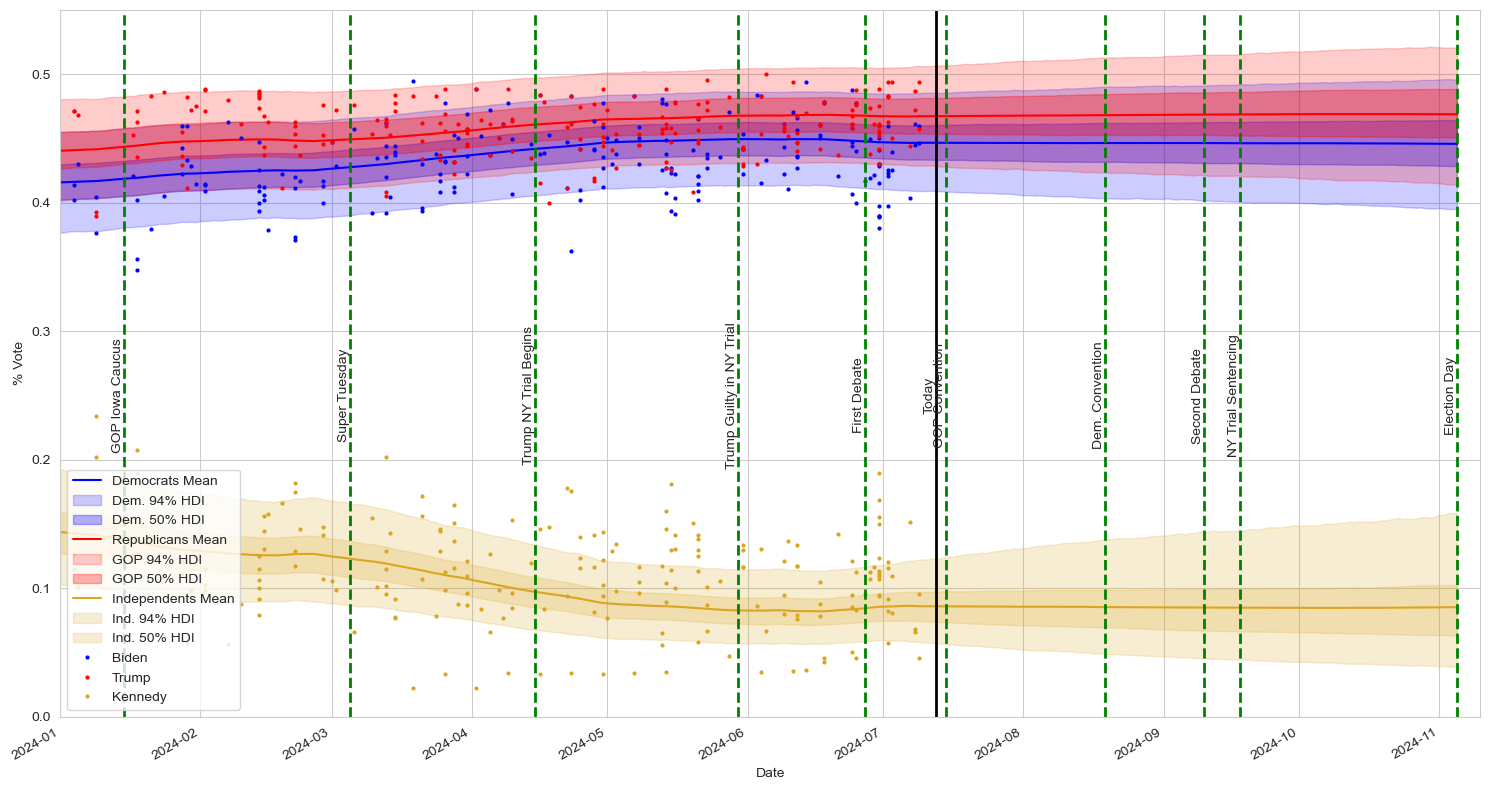

In [220]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

df_day_mean[f"{graph_state}_ind"].plot(color='goldenrod', label='Independents Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_ind"].ffill(), df_day_97[f"{graph_state}_ind"].ffill(), color='goldenrod', alpha=0.2, label='Ind. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_ind"].ffill(), df_day_75[f"{graph_state}_ind"].ffill(), color='goldenrod', alpha=0.2, label='Ind. 50% HDI')

dem_votes3 = df_3way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes3 = df_3way.set_index('date').query(f"state == '{graph_state}'")["GOP"]
ind_votes3 = df_3way.set_index('date').query(f"state == '{graph_state}'")["IND"]

ax.plot(dem_votes3.index, dem_votes3, "o", alpha=1, color='blue', label="Biden", markersize=2)
ax.plot(gop_votes3.index, gop_votes3, "o", alpha=1, color='red', label="Trump", markersize=2)
ax.plot(ind_votes3.index, ind_votes3, "o", alpha=1, color='goldenrod', label="Kennedy", markersize=2)

dem_votes2 = df_2way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes2 = df_2way.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes2.index, dem_votes2, "s", alpha=1, color='blue', label="Biden", markersize=10)
#ax.plot(gop_votes2.index, gop_votes2, "s", alpha=1, color='red', label="Trump", markersize=10)

# Set limits and labels
ax.set_ylim(0, .55)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend(loc='lower left')

events = [
            (dt.datetime(2024, 1, 15), 'GOP Iowa Caucus'),
            (dt.datetime(2024, 3,  5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 15), 'GOP Convention'),
            (dt.datetime(2024, 8, 19), 'Dem. Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.25, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.25, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('3way_enight_natpoll.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_63499/2095396073.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_63499/2095396073.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

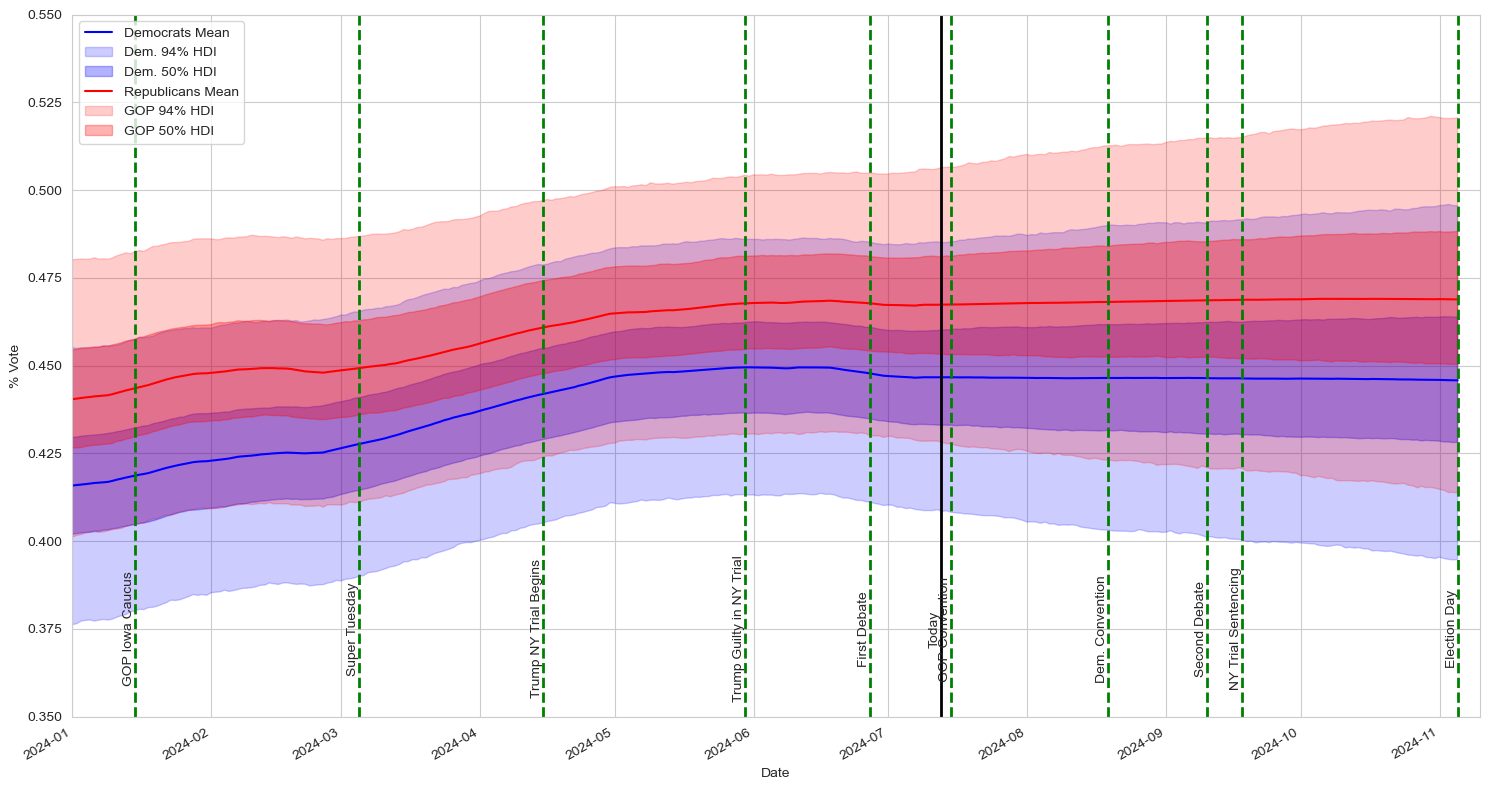

In [218]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

dem_votes = df_3way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df_3way.set_index('date').query(f"state == '{graph_state}'")["GOP"]
ind_votes = df_3way.set_index('date').query(f"state == '{graph_state}'")["IND"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=0.2, color='red', label="Trump")
#ax.plot(ind_votes.index, ind_votes, "o", alpha=0.2, color='goldenrod', label="Kennedy")

# Set limits and labels
ax.set_ylim(.35, .55)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend(loc='upper left')

events = [
            (dt.datetime(2024, 1, 15), 'GOP Iowa Caucus'),
            (dt.datetime(2024, 3,  5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 15), 'GOP Convention'),
            (dt.datetime(2024, 8, 19), 'Dem. Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.375, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.375, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('3way_enight_natpoll.png')

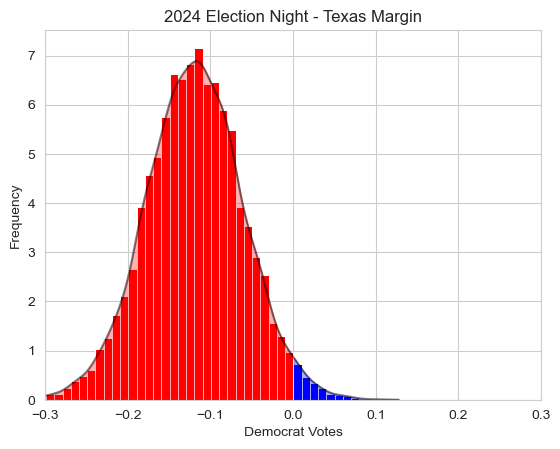

In [226]:
# TX, CA, MN, MI, FL, GA

graph_state = 'TX'

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_results[f"{graph_state}_margin"], binwidth=.01, kde=False, stat="density")

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() + 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 0:
        patch.set_facecolor('red')
    elif x > 0:
        patch.set_facecolor('blue')
    elif x == 0:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('green')

# Plot KDE
kde_ax = sns.kdeplot(df_results[f"{graph_state}_margin"], color='black', alpha = 0.5, ax=ax)

# Fill area above 270 with red color
kde_x, kde_y = kde_ax.get_lines()[0].get_data()
kde_ax.fill_between(kde_x, kde_y, where=(kde_x >= 0), color='blue', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x <= 0), color='red', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x == 0), color='lime', alpha=1)


# Adding titles and labels
plt.title('2024 Election Night - Texas Margin')
plt.xlabel('Democrat Votes')
plt.xlim(-.3, .3)
plt.ylabel('Frequency')

events = [
    #(13, 'Mondale 1984'),
    #(49, 'Carter 1980'),
    #(486, 'Johnson 1964')
]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    plt.text(date, .05, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

# Display the plot
plt.savefig('3way_enight_tx.png')


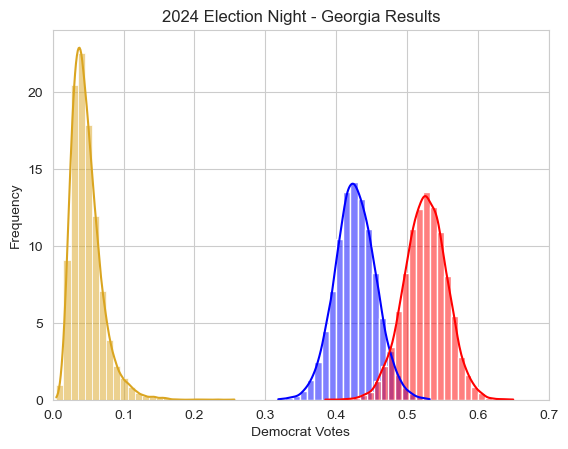

In [191]:
# TX, CA, MN, MI, FL, GA

graph_state = 'GA'

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_results[f"{graph_state}_dem"], color='blue', binwidth=.01, kde=True, stat="density")
ax = sns.histplot(df_results[f"{graph_state}_gop"], color='red', binwidth=.01, kde=True, stat="density")
ax = sns.histplot(df_results[f"{graph_state}_ind"], color='goldenrod', binwidth=.01, kde=True, stat="density")

# Adding titles and labels
plt.title('2024 Election Night - Georgia Results')
plt.xlabel('Democrat Votes')
plt.xlim(0, .7)
plt.ylabel('Frequency')

events = [
    #(13, 'Mondale 1984'),
    #(49, 'Carter 1980'),
    #(486, 'Johnson 1964')
]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    plt.text(date, .05, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

# Display the plot
plt.savefig('3way_enight_ga.png')

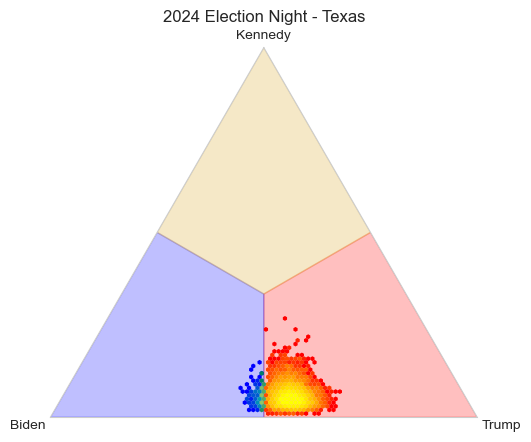

In [216]:
graph_data = pd.DataFrame()
graph_data[['ind','dem','gop']] = round(df_results[['TX_ind','TX_dem','TX_gop']],2)

duplicate_rows = graph_data[graph_data.duplicated(keep=False)]
duplicate_counts = duplicate_rows.groupby(list(graph_data.columns)).size().reset_index(name='count')
max_duplicates = duplicate_counts['count'].max()

graph_data_ind = graph_data[graph_data['ind'] > graph_data[['dem', 'gop']].max(axis=1)]
graph_data_dem = graph_data[graph_data['dem'] > graph_data[['ind', 'gop']].max(axis=1)]
graph_data_gop = graph_data[graph_data['gop'] > graph_data[['dem', 'ind']].max(axis=1)]
graph_data_tie = graph_data[((graph_data['ind'] == graph_data.max(axis=1)).astype(int) +
 (graph_data['gop'] == graph_data.max(axis=1)).astype(int) +
 (graph_data['dem'] == graph_data.max(axis=1)).astype(int)) > 1]

ax = plt.subplot(projection="ternary")

ax.set_tlabel('Kennedy')
ax.set_llabel('Biden')
ax.set_rlabel('Trump')
ax.taxis.set_label_rotation_mode('horizontal')
ax.laxis.set_label_rotation_mode('horizontal')
ax.raxis.set_label_rotation_mode('horizontal')

# Specify tick positions manually.
ticks = []
labels = []
ax.taxis.set_ticks(ticks, labels=labels)
ax.laxis.set_ticks(ticks, labels=labels)
ax.raxis.set_ticks(ticks, labels=labels)

t = [0, 0.5, 0.3333,0]
l = [0, 0, 0.3333,0.5]
r = [1, 0.5,0.3333, 0.5]
ax.fill(t, l, r, alpha=0.25, color='red')

t = [0, 0.5, 0.3333,0]
r = [0, 0, 0.3333,0.5]
l = [1, 0.5,0.3333, 0.5]
ax.fill(t, l, r, alpha=0.25, color='blue')

r = [0, 0.5, 0.3333,0]
l = [0, 0, 0.3333,0.5]
t = [1, 0.5,0.3333, 0.5]
ax.fill(t, l, r, alpha=0.25, color='goldenrod')

ax.hexbin(graph_data_ind['ind'], graph_data_ind['dem'], graph_data_ind['gop'],bins="log", cmap='cool', edgecolors="none", vmin=1, vmax=max_duplicates, gridsize=101)
ax.hexbin(graph_data_dem['ind'], graph_data_dem['dem'], graph_data_dem['gop'],bins="log", cmap='winter', edgecolors="none", vmin=1,vmax=max_duplicates, gridsize=101)
ax.hexbin(graph_data_gop['ind'], graph_data_gop['dem'], graph_data_gop['gop'],bins="log", cmap='autumn', edgecolors="none", vmin=1,vmax=max_duplicates, gridsize=101)
ax.hexbin(graph_data_tie['ind'], graph_data_tie['dem'], graph_data_tie['gop'],bins="log", cmap='summer', edgecolors="none", vmin=1, vmax=max_duplicates, gridsize=101)

plt.title('2024 Election Night - Texas')
plt.savefig('tern_enight_tx.png')

In [193]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    ind_votes = df_results[f"{state}_ind"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > max(gop_votes[i], ind_votes[i])
         else "gop" if gop_votes[i] > max(dem_votes[i], ind_votes[i])
         else "ind" if ind_votes[i] > max(dem_votes[i], gop_votes[i])
         else "tie"
         for i in range(len(df_results))]
    )

In [194]:
df_state = pd.read_csv("../Data/clean/state_code.csv")

In [195]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

7       DE
30    NE-1
32    NE-3
56      DC
Name: state_code, dtype: object

In [196]:
#df_winner['AR'] = df_winner['TN']
#df_winner['CT'] = df_winner['NJ']
df_winner['DE'] = df_winner['NC']
#df_winner['ID'] = df_winner['MT']
#df_winner['IL'] = df_winner['IN']
#df_winner['KS'] = df_winner['NE']
#df_winner['KY'] = df_winner['AL']
#df_winner['ME-1'] = df_winner['RI']
#df_winner['ME-2'] = df_winner['TX']
#df_winner['MS'] = df_winner['SC']
df_winner['NE-1'] = df_winner['SC']
df_winner['NE-3'] = df_winner['WV']
#df_winner['ND'] = df_winner['SD']
#df_winner['WY'] = df_winner['CO']
df_winner['DC'] = df_winner['CA']

#df_winner[['AR', 'ID', 'KS', 'KY', 'ME-2', 'MS', 'NE-1', 'NE-3', 'ND', 'WY']] = 'gop'
#df_winner[['CT', 'DE', 'IL','ME-1', 'DC']] = 'dem'

state_order = df_state['state_code'].to_list

In [197]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0, 'ind': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0, 'ind': 0})
df_winner_ind = df_winner.replace({'ind': 1, 'dem': 0, 'gop': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_63499/4278642740.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0, 'ind': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_63499/4278642740.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0, 'ind': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_63499/4278642740.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and

In [198]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['ind'] = df_winner_ind.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)

In [199]:
df_ec

,dem,gop,ind
0,165,373,0
1,120,418,0
2,165,373,0
3,89,449,0
4,97,441,0
...,...,...,...
9995,131,407,0
9996,211,327,0
9997,175,363,0
9998,229,309,0


In [200]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(13.36, 0.22999999999999998, 86.41)

In [201]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['gop'] > 269])
equal_to_270 = len(df_ec[df_ec['gop'] == 269])
lower_than_270 = len(df_ec[df_ec['gop'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(86.41, 0.22999999999999998, 13.36)

In [202]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['ind'] > 269])
equal_to_270 = len(df_ec[df_ec['ind'] == 269])
lower_than_270 = len(df_ec[df_ec['ind'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(0.0, 0.0, 100.0)

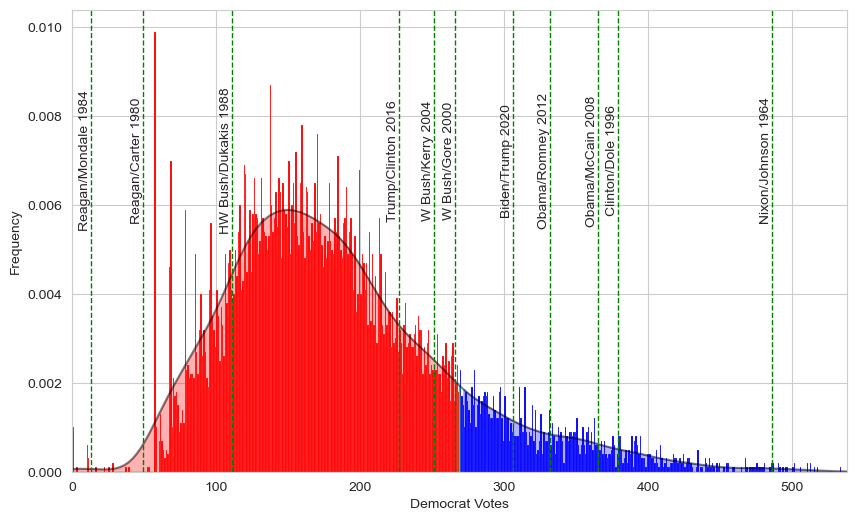

In [217]:
# Plotting the histograms
plt.figure(figsize=(10, 6))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_ec['dem'], binwidth=1, kde=False, stat="density")

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() + 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('green')

# Plot KDE
kde_ax = sns.kdeplot(df_ec['dem'], color='black', alpha = 0.5, ax=ax)

# Fill area above 270 with red color
kde_x, kde_y = kde_ax.get_lines()[0].get_data()
kde_ax.fill_between(kde_x, kde_y, where=(kde_x >= 270), color='blue', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x <= 268), color='red', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x > 268) & (kde_x < 270), color='lime', alpha=1)


# Adding titles and labels
#plt.title('2024 Election Night - Electoral College Results')
plt.xlabel('Democrat Votes')
plt.xlim(0, 538)
plt.ylabel('Frequency')

events = [
    (13, 'Reagan/Mondale 1984'),
    (49, 'Reagan/Carter 1980'),
    (111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    (365, 'Obama/McCain 2008'),
    (379, 'Clinton/Dole 1996'),
    (486, 'Nixon/Johnson 1964')
]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    plt.text(date, .007, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

# Display the plot
plt.savefig('3way_enight_ec.png')

In [204]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)
df_win_pct['ind'] = df_winner_ind.mean(axis=0)

In [205]:
df_win_pct.sort_values('ind')

,dem,gop,ind
VA,0.6603,0.3397,0.0000
HI,0.3605,0.6395,0.0000
OR,0.3989,0.6011,0.0000
OK,0.0466,0.9534,0.0000
NJ,0.3393,0.6607,0.0000
IN,0.1554,0.8446,0.0000
AL,0.1463,0.8537,0.0000
TN,0.0092,0.9908,0.0000
VT,0.2754,0.7246,0.0000
IA,0.0563,0.9437,0.0000


In [206]:
df_mean = pd.DataFrame(index=states, columns=['dem','ind','gop'])

for state in states:
    df_mean.loc[state, 'dem'] = df_results[f"{state}_dem"].mean()
    df_mean.loc[state, 'ind'] = df_results[f"{state}_ind"].mean()
    df_mean.loc[state, 'gop'] = df_results[f"{state}_gop"].mean()    

In [207]:
df_mean.sort_values('ind')

,dem,ind,gop
GA,0.426841,0.047567,0.525592
NC,0.436444,0.049776,0.513781
PA,0.450053,0.050851,0.499096
FL,0.427586,0.051049,0.521366
AZ,0.435444,0.052397,0.512159
WI,0.461076,0.052735,0.486188
OH,0.416522,0.053156,0.530322
MN,0.474749,0.053509,0.471742
NH,0.48172,0.053756,0.464524
MI,0.455797,0.054069,0.490134
